Imports

In [1]:
import numpy as np
import os          
import matplotlib.pyplot as plt           
import cv2 as cv                                
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tqdm import tqdm  
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  
from sklearn.utils import shuffle

Classes

In [2]:
class_names = ['card', 'glass', 'metal', 'paper', 'plastic']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

new_size = (71,71)

Função para carregar dataset

In [40]:
def load_data():
    
    
    datasets = ['dataset/train', 'dataset/test']
    output = []
    
    # Loop para o dataset train e test
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Loop em cada uma das pastas
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Loop dentro da pasta para as imagens
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Obtem o caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Le cada imagem e redimensiona-la
                image = cv.imread(img_path)
                
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, new_size) 

                # Normalizar
                image = image / 255.0

                # Adiciona a imagem e label correspondente à array
                images.append(image)
                labels.append(label)
                  
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

Carregar e dividir dataset

In [41]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading dataset/train


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:13<00:00, 60.59it/s]


Loading dataset/test


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 64.64it/s]


Salvar arrays de imagens e labels para usar noutros ficheiros

In [3]:
#np.save('arraysTrainTest/train_images71.npy', train_images)
#np.save('arraysTrainTest/train_labels71.npy', train_labels)
#np.save('arraysTrainTest/test_images71.npy', test_images)
#np.save('arraysTrainTest/test_labels71.npy', test_labels)
train_images = np.load('arraysTrainTest/train_images71.npy')
train_labels = np.load('arraysTrainTest/train_labels71.npy')
test_images = np.load('arraysTrainTest/test_images71.npy')
test_labels = np.load('arraysTrainTest/test_labels71.npy')
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Rede Neuronal

In [5]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))

# Congelar camadas do modelo pré-treinado
for layer in base_model.layers:
    layer.trainable = False
    
callback = callbacks.EarlyStopping(monitor='loss', patience=3)    

model = models.Sequential([
    base_model,
    layers.Flatten(),  
    layers.Dense(253.184, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(253.184, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer= optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, validation_split = 0.2, batch_size=64)

loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss}\nAccuracy: {accuracy}")

Epoch 1/10
7/7 [==============================] - 15s 1s/step - loss: 1.3690 - accuracy: 0.4375 - val_loss: 0.9010 - val_accuracy: 0.6800
Epoch 2/10
7/7 [==============================] - 6s 917ms/step - loss: 0.7318 - accuracy: 0.7800 - val_loss: 0.6454 - val_accuracy: 0.7800
Epoch 3/10
7/7 [==============================] - 6s 878ms/step - loss: 0.4990 - accuracy: 0.8400 - val_loss: 0.5082 - val_accuracy: 0.8000
Epoch 4/10
7/7 [==============================] - 7s 961ms/step - loss: 0.3949 - accuracy: 0.8750 - val_loss: 0.5060 - val_accuracy: 0.8100
Epoch 5/10
7/7 [==============================] - 7s 1s/step - loss: 0.3360 - accuracy: 0.8900 - val_loss: 0.5317 - val_accuracy: 0.7800
Epoch 6/10
7/7 [==============================] - 7s 1s/step - loss: 0.2887 - accuracy: 0.9300 - val_loss: 0.4636 - val_accuracy: 0.8000
Epoch 7/10
7/7 [==============================] - 7s 1s/step - loss: 0.2412 - accuracy: 0.9275 - val_loss: 0.4195 - val_accuracy: 0.8100
Epoch 8/10
7/7 [===============

Salvar modelo e fit

In [18]:
model.save('PSO.model')
np.save('arraysHistory/history_PSO.npy', history.history)

INFO:tensorflow:Assets written to: PSO.model\assets


INFO:tensorflow:Assets written to: PSO.model\assets


Gráfico Accuracy de Treino e Validação

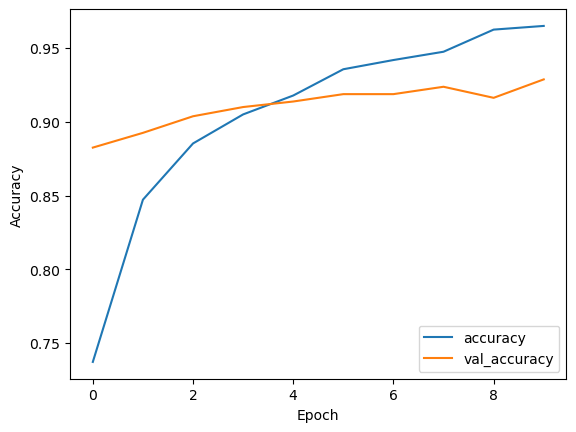

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('imagens/plots/datasetcompleto.jpg')
plt.show()


Matriz Confusão

25/25 [==============================] - 7s 242ms/step


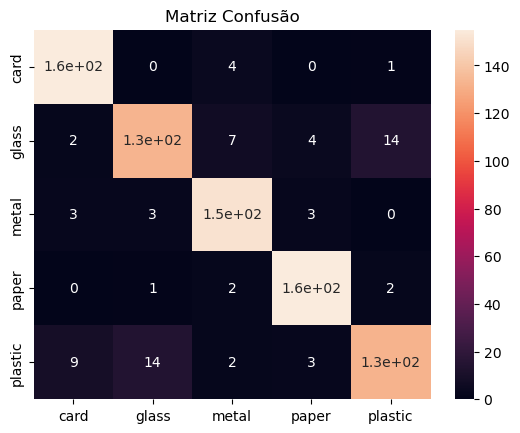

In [45]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

CM = confusion_matrix(test_labels, predicted_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
            annot_kws={"size": 10}, 
            xticklabels=class_names, 
            yticklabels=class_names, ax = ax)
ax.set_title('Matriz Confusão')
plt.savefig("imagens/matriz/GridSearch.jpg")
plt.show()

Performance

In [46]:
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f_measure = f1_score(test_labels, predicted_labels, average='weighted')
auc = roc_auc_score(test_labels, predictions, multi_class='ovr', average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Measure: {f_measure}")
print(f"AUC: {auc}")

Accuracy: 0.9075
Precision: 0.9065785998359255
Recall: 0.9075
F-Measure: 0.9064300320685342
AUC: 0.9857285156250001


Testes personalizados

1/1 [==============================] - 0s 65ms/step
I am 98.62% sure it is plastic


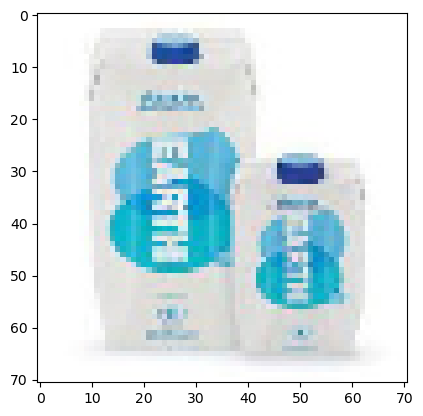

In [16]:
img = cv.imread('imagensTeste/cartaoTeste2.jpeg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, new_size)

plt.imshow(img, cmap=plt.cm.binary)

prediction = model.predict(np.array([img]) / 255)
index = np.argmax(prediction)
confidence = prediction[0][index] * 100

print(f"I am {confidence:.2f}% sure it is {class_names[index]}")